In [1]:
# import packages

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('events_log.csv')

In [3]:
df.shape

(400165, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 9 columns):
uuid               400165 non-null object
timestamp          400165 non-null float64
session_id         400165 non-null object
group              400165 non-null object
action             400165 non-null object
checkin            223824 non-null float64
page_id            400165 non-null object
n_results          136234 non-null float64
result_position    230482 non-null float64
dtypes: float64(4), object(5)
memory usage: 27.5+ MB


In [5]:
df.describe()

,timestamp,checkin,n_results,result_position
count,4.001650e+05,223824.000000,136234.000000,230482.000000
mean,2.016030e+13,97.190382,13.210109,2.992798
std,2.340996e+06,104.593714,13.271104,38.557292
min,2.016030e+13,10.000000,0.000000,1.000000
25%,2.016030e+13,20.000000,2.000000,1.000000
50%,2.016030e+13,50.000000,20.000000,1.000000
75%,2.016031e+13,150.000000,20.000000,2.000000
max,2.016031e+13,420.000000,500.000000,4103.000000


In [6]:
# Find duplicates
df[df.duplicated()]

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position


In [7]:
# Convert timestamp to datetime
df.timestamp =  pd.to_datetime(df.timestamp.astype('int64'), format='%Y%m%d%H%M%S', utc=True)

In [8]:
# Convert action and group to Category
df.action = df.action.astype('category')
df.group = df.group.astype('category')

In [9]:
# Convert session_id to categorical
df.session_id = df.session_id.astype('category')
df.page_id = df.page_id.astype('category')

In [10]:
# Daily Click Through Rate
df['day_of_week'] = df.timestamp.dt.day_name()

In [11]:
df['time'] = df.timestamp.dt.time

In [12]:
df['week'] = df.timestamp.dt.week

In [13]:
# Create Ordered Category for the Days
cat_type = pd.api.types.CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [14]:
# Change Day of Week to Categorical Type
df['day_of_week'] = df.day_of_week.astype(cat_type)

In [15]:
df['date'] = df.timestamp.dt.date

In [16]:
def get_session_duration(timestamp):
    return pd.Timedelta(max(timestamp) - min(timestamp)).seconds

In [17]:
session_duration_df = df.groupby('session_id')['timestamp'].agg(get_session_duration).reset_index(name="session_duration")

In [18]:
session_duration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68028 entries, 0 to 68027
Data columns (total 2 columns):
session_id          68028 non-null category
session_duration    68028 non-null int64
dtypes: category(1), int64(1)
memory usage: 3.8 MB


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 13 columns):
uuid               400165 non-null object
timestamp          400165 non-null datetime64[ns, UTC]
session_id         400165 non-null category
group              400165 non-null category
action             400165 non-null category
checkin            223824 non-null float64
page_id            400165 non-null category
n_results          136234 non-null float64
result_position    230482 non-null float64
day_of_week        400165 non-null category
time               400165 non-null object
week               400165 non-null int64
date               400165 non-null object
dtypes: category(5), datetime64[ns, UTC](1), float64(3), int64(1), object(3)
memory usage: 38.0+ MB


In [20]:
df = df.merge(session_duration_df, on="session_id")

In [21]:
df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day_of_week,time,week,date,session_duration
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42+00:00,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,Tuesday,10:38:42,9,2016-03-01,44
1,004690364c695f04b5d045913e1bdf7c,2016-03-01 10:39:16+00:00,78245c2c3fba013a,b,checkin,30.0,2f0e04bd56649f43,NaN,3.0,Tuesday,10:39:16,9,2016-03-01,44
2,0af62216356759fea26313e155f70809,2016-03-01 10:39:26+00:00,78245c2c3fba013a,b,checkin,40.0,2f0e04bd56649f43,NaN,3.0,Tuesday,10:39:26,9,2016-03-01,44
3,14601aeb2bf058af9380c1644e606e24,2016-03-01 10:39:06+00:00,78245c2c3fba013a,b,checkin,20.0,2f0e04bd56649f43,NaN,3.0,Tuesday,10:39:06,9,2016-03-01,44
4,33922e14b6bb5e27823481a3c44ed462,2016-03-01 10:38:56+00:00,78245c2c3fba013a,b,checkin,10.0,2f0e04bd56649f43,NaN,3.0,Tuesday,10:38:56,9,2016-03-01,44


### Computing and Visualizing the Daily Clickthrough Rate

For a given session we find the number of `action = 'visitPage'`  and divide by the total actions.

In [22]:
default_colour = sb.color_palette()[0]

In [23]:
def is_clicked_link(action):
     return any(action == 'visitPage')

In [24]:
# overall clickthrough rate
overall_clickthrough_rate =  df.groupby('session_id')['action'].agg(is_clicked_link).mean()
print(overall_clickthrough_rate)

0.3888398894572823


In [25]:
clickthrough_df = df.groupby(['date','day_of_week','session_id', 'group'])['action'].agg(is_clicked_link).reset_index(name='is_clicked_link')

In [26]:
clickthrough_df['group'] = clickthrough_df.group.astype('category')
clickthrough_df['session_id'] = clickthrough_df.session_id.astype('category')
clickthrough_df['day_of_week'] = clickthrough_df.day_of_week.astype(cat_type)

In [27]:
clickthrough_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68111 entries, 0 to 68110
Data columns (total 5 columns):
date               68111 non-null datetime64[ns]
day_of_week        68111 non-null category
session_id         68111 non-null category
group              68111 non-null category
is_clicked_link    68111 non-null bool
dtypes: bool(1), category(3), datetime64[ns](1)
memory usage: 4.0 MB


In [28]:
clickthrough_df.head()

,date,day_of_week,session_id,group,is_clicked_link
0,2016-03-01,Tuesday,000936ae06d62383,b,False
1,2016-03-01,Tuesday,001544bc03fac3e8,b,False
2,2016-03-01,Tuesday,001a3950cd4ac6c6,a,False
3,2016-03-01,Tuesday,001e2d0e159172d2,b,True
4,2016-03-01,Tuesday,0022bba0634595b9,b,False


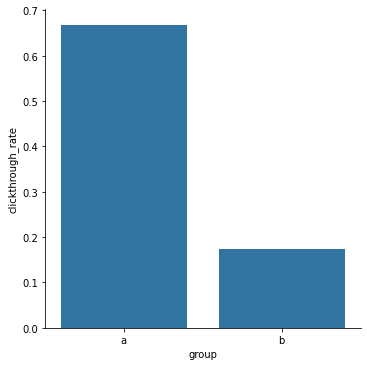

In [29]:
# Clickthrough Rate Per Group
group_clickthrough =  clickthrough_df.groupby('group').mean()['is_clicked_link'].reset_index(name="clickthrough_rate")
sb.catplot(data=group_clickthrough, x='group', y="clickthrough_rate", kind="bar", color=default_colour);

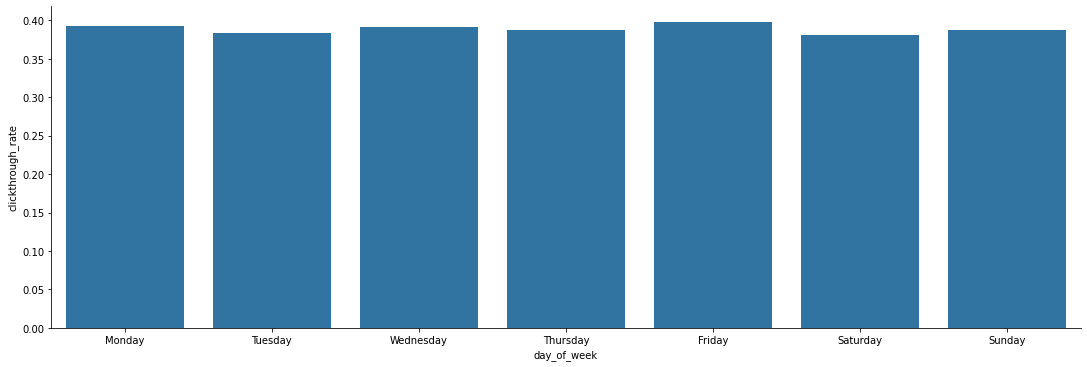

In [30]:
daily_clickthrough = clickthrough_df.groupby(['day_of_week']).mean()['is_clicked_link'].reset_index(name="clickthrough_rate")
sb.catplot(data=daily_clickthrough, x='day_of_week', y="clickthrough_rate", kind="bar", color=default_colour, aspect=3);

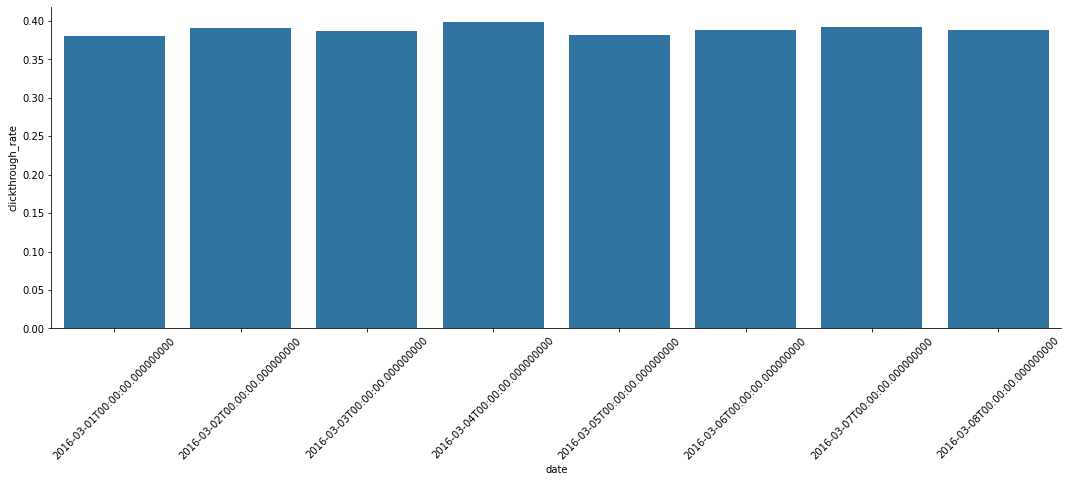

In [31]:
# Daily Clickthrough Rate using Date
date_clickthrough = clickthrough_df.groupby('date').mean()['is_clicked_link'].reset_index(name="clickthrough_rate")
sb.catplot(data=date_clickthrough, x='date', y="clickthrough_rate", kind="bar", color=default_colour, aspect=3);
plt.xticks(rotation=45);

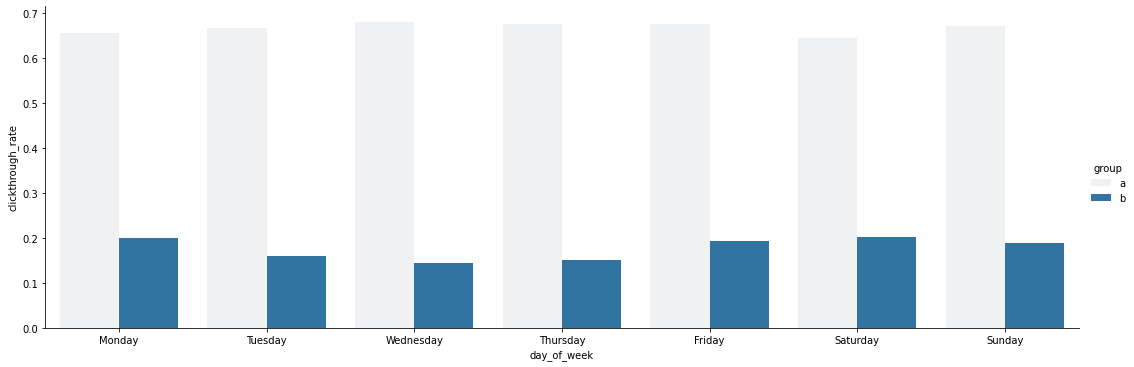

In [32]:
# Daily Clickthrough Rate using Day and Group
daily_clickthrough_group = clickthrough_df.groupby(['group','day_of_week']).mean()['is_clicked_link'].reset_index(name="clickthrough_rate")
sb.catplot(data=daily_clickthrough_group, x='day_of_week', y="clickthrough_rate", hue="group", kind="bar", color=default_colour, aspect=3);

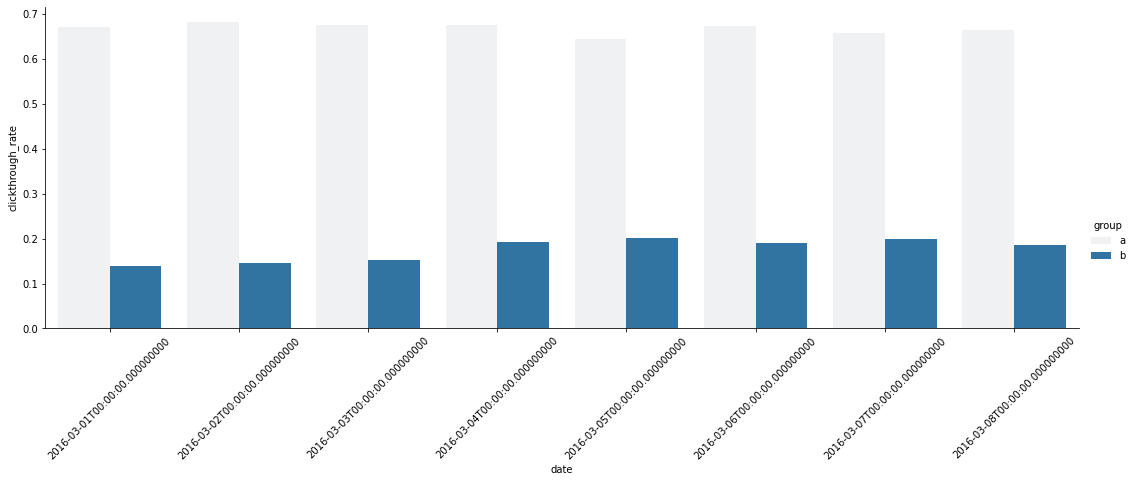

In [33]:
# Daily Clickthrough Rate using Date and Group
date_clickthrough_group = clickthrough_df.groupby(['group','date']).mean()['is_clicked_link'].reset_index(name="clickthrough_rate")
sb.catplot(data=date_clickthrough_group, x='date', y="clickthrough_rate", hue="group", kind="bar", color=default_colour, aspect=3);
plt.xticks(rotation=45);

## **Zero Result Rates**

In [34]:
serp_df = df.query('action == "searchResultPage"')
serp_df['is_zero_result'] = serp_df.apply(lambda x: True if (x.n_results == 0) else False , axis=1)
serp_df.head()

/home/mupati/.virtualenvs/azure-ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day_of_week,time,week,date,session_duration,is_zero_result
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42+00:00,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,Tuesday,10:38:42,9,2016-03-01,44,False
6,00000c69fe345268935463abbfa5d5b3,2016-03-07 00:52:26+00:00,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN,Monday,00:52:26,10,2016-03-07,438,False
7,1115445e1557545eb9e1417a5b31c1a0,2016-03-07 00:52:30+00:00,c559c3be98dca8a4,a,searchResultPage,NaN,149f86f76a3b39bd,20.0,NaN,Monday,00:52:30,10,2016-03-07,438,False
8,1e2254f1e755535e8e86eb5786d90f44,2016-03-07 00:47:47+00:00,c559c3be98dca8a4,a,searchResultPage,NaN,fb94aee9822c380d,10.0,NaN,Monday,00:47:47,10,2016-03-07,438,False
9,21a94344ba3f5d9e9fd2449c0135cfd0,2016-03-07 00:49:29+00:00,c559c3be98dca8a4,a,searchResultPage,NaN,ea8a1cf52597df28,20.0,NaN,Monday,00:49:29,10,2016-03-07,438,False


In [35]:
# Overall Zero Results Rate
overall_zero_results_rate = np.mean(serp_df.is_zero_result)
print(overall_zero_results_rate)

0.18444000763392399


  group  zero_results_rate
0     a           0.183606
1     b           0.186179


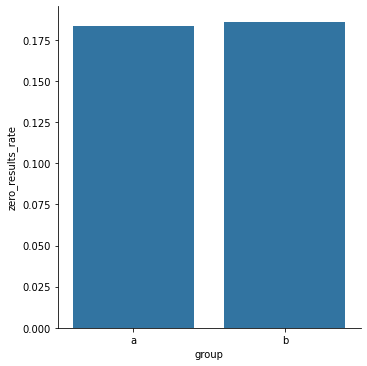

In [36]:
# Zero Results Rate Rate Per Group
group_zero_results_rate =  serp_df.groupby('group').mean()['is_zero_result'].reset_index(name="zero_results_rate")
print(group_zero_results_rate)
sb.catplot(data=group_zero_results_rate, x='group', y="zero_results_rate", kind="bar", color=default_colour);

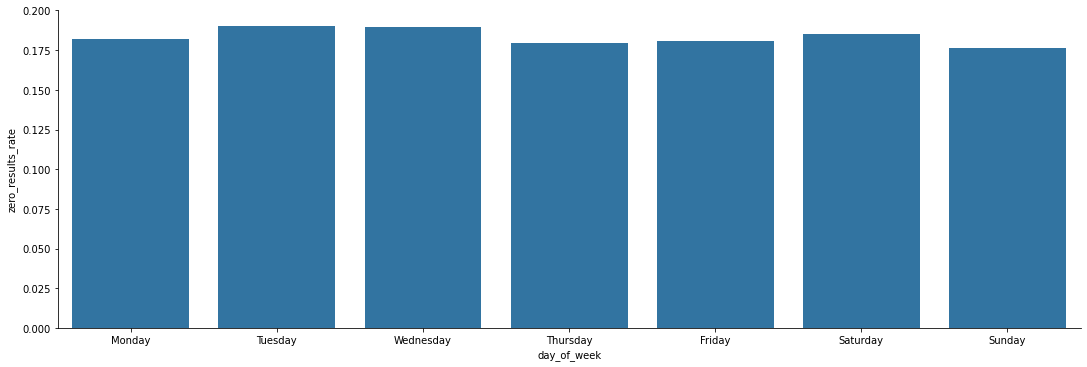

In [37]:
daily_zero_results_rate = serp_df.groupby(['day_of_week']).mean()['is_zero_result'].reset_index(name="zero_results_rate")
sb.catplot(data=daily_zero_results_rate, x='day_of_week', y="zero_results_rate", kind="bar", color=default_colour, aspect=3);

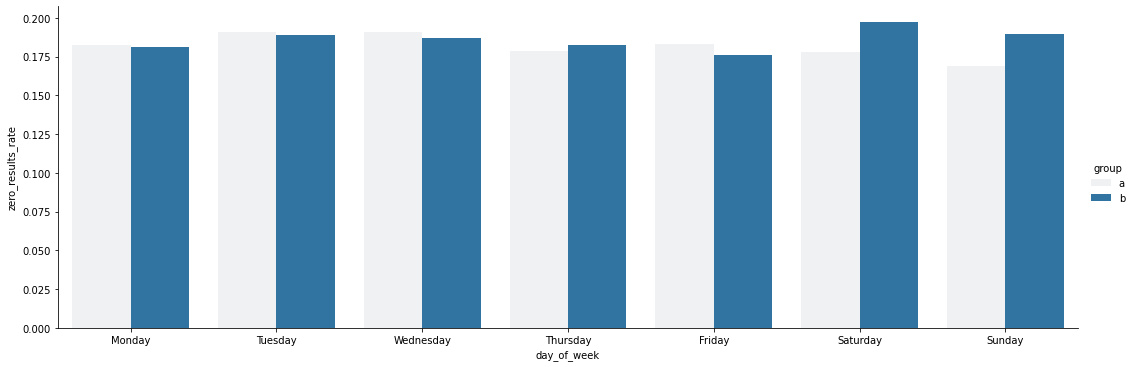

In [38]:
# Zero Results Rate using Day and Group
daily_zero_results_group = serp_df.groupby(['group','day_of_week']).mean()['is_zero_result'].reset_index(name="zero_results_rate")
sb.catplot(data=daily_zero_results_group, x='day_of_week', y="zero_results_rate", hue="group", kind="bar", color=default_colour, aspect=3);

## Which Result do people tend to choose first

In [39]:
df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day_of_week,time,week,date,session_duration
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42+00:00,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,Tuesday,10:38:42,9,2016-03-01,44
1,004690364c695f04b5d045913e1bdf7c,2016-03-01 10:39:16+00:00,78245c2c3fba013a,b,checkin,30.0,2f0e04bd56649f43,NaN,3.0,Tuesday,10:39:16,9,2016-03-01,44
2,0af62216356759fea26313e155f70809,2016-03-01 10:39:26+00:00,78245c2c3fba013a,b,checkin,40.0,2f0e04bd56649f43,NaN,3.0,Tuesday,10:39:26,9,2016-03-01,44
3,14601aeb2bf058af9380c1644e606e24,2016-03-01 10:39:06+00:00,78245c2c3fba013a,b,checkin,20.0,2f0e04bd56649f43,NaN,3.0,Tuesday,10:39:06,9,2016-03-01,44
4,33922e14b6bb5e27823481a3c44ed462,2016-03-01 10:38:56+00:00,78245c2c3fba013a,b,checkin,10.0,2f0e04bd56649f43,NaN,3.0,Tuesday,10:38:56,9,2016-03-01,44


In [40]:
# Find the Results that were clicked and have an assigned position number
clicked_results_with_position = df.query('action == "visitPage" and result_position.notna()')

In [41]:
# Convert the result position number to int.
clicked_results_with_position.result_position = clicked_results_with_position.result_position.astype('int64')

/home/mupati/.virtualenvs/azure-ml/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [55]:
clicked_results_with_position.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day_of_week,time,week,date,session_duration
5,36af0358f25155fb8978d5f50737d432,2016-03-01 10:38:46+00:00,78245c2c3fba013a,b,visitPage,NaN,2f0e04bd56649f43,NaN,3,Tuesday,10:38:46,9,2016-03-01,44
33,62ba040aa2775572ad30a1aca140fee8,2016-03-02 14:43:09+00:00,760bf89817ce4b08,a,visitPage,NaN,4d306d4827f4fade,NaN,1,Wednesday,14:43:09,9,2016-03-02,627
39,962aa581f1f4570b81e71f6faa52d70e,2016-03-02 14:49:15+00:00,760bf89817ce4b08,a,visitPage,NaN,b25a59573344207a,NaN,1,Wednesday,14:49:15,9,2016-03-02,627
47,cf3f95e7327e537499927e0488ae38be,2016-03-02 14:45:39+00:00,760bf89817ce4b08,a,visitPage,NaN,ea7f2e3f09201d2e,NaN,3,Wednesday,14:45:39,9,2016-03-02,627
57,06f149eaeaf15c54b7691c883a7c909a,2016-03-02 22:20:26+00:00,fb905603d31b2071,a,visitPage,NaN,213a19adac7f7d34,NaN,30,Wednesday,22:20:26,9,2016-03-02,2278


In [42]:
# For each session, choose the one that was clicked first.
grouped_sesssion = clicked_results_with_position.groupby('session_id')

In [114]:
plot_data = grouped_sesssion[['timestamp', 'result_position']].apply(lambda g: g[g['timestamp'] == g['timestamp'].min()]).reset_index()

In [120]:
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26450 entries, 0 to 26449
Data columns (total 4 columns):
session_id         26450 non-null category
level_1            26450 non-null int64
timestamp          26450 non-null datetime64[ns, UTC]
result_position    26450 non-null int64
dtypes: category(1), datetime64[ns, UTC](1), int64(2)
memory usage: 3.7 MB


In [121]:
# Get results with position <= 20
plot_data = plot_data.query('result_position <= 20')

In [122]:
plot_data.describe()

,level_1,result_position
count,26386.000000,26386.000000
mean,215794.091602,2.047184
std,110292.679531,2.488467
min,5.000000,1.000000
25%,124876.250000,1.000000
50%,226678.500000,1.000000
75%,312945.750000,2.000000
max,399937.000000,20.000000


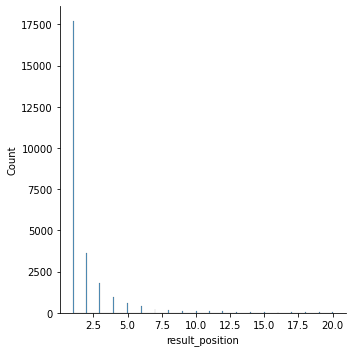

In [123]:
sb.displot(data=plot_data, x='result_position');

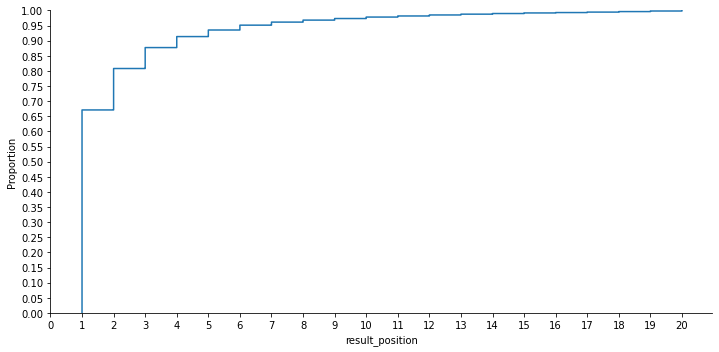

In [130]:
sb.displot(data=plot_data, x="result_position", kind="ecdf", aspect=2);
plt.xticks(np.arange(0,21,1));
plt.yticks(np.arange(0,1.05,0.05));